# Forward model using the Waveform Simulator

*Bart Pelssers, 27-03-2018, last update 20-04-2018*

Provides forward model for the ABC project using the Pax Waveform Simulator (Fax).


In [1]:
import numpy as np

In [2]:
from abc_reconstruction.model import Model

In [3]:
# Initialize the forward model
model = Model('XENON1T_ABC.ini')  # or use 'XENON1T_ABC.ini' to have some top PMTs off

You don't have ROOT or root_pandas, root truth file output is disabled


In [4]:
# OPTIONALLY: Set different defaults for z,t,recoil_type,s1_photons_s2_electrons
model.change_defaults(s2_electrons = 100)

In [5]:
# View the current defaults
model.input_plugin.default_instruction

{'g4_id': -1,
 'recoil_type': 'NR',
 's1_photons': '50',
 's2_electrons': '100',
 't': '10000',
 'x': 0.0,
 'y': 0.0,
 'z': '0.0'}

In [6]:
# Call the forward model with a certain x,y (and the other default settings)
model(0, 45)

array([6.36139614e+01, 0.00000000e+00, 0.00000000e+00, 6.70662446e+01,
       2.00503658e+01, 1.00582991e+01, 5.44128219e+00, 5.36245097e-01,
       1.38006284e+00, 6.61282091e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.45943658e+00, 0.00000000e+00, 6.85469749e-01, 2.20019663e+00,
       0.00000000e+00, 3.66815723e+00, 0.00000000e+00, 1.46899344e+00,
       1.16835113e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.68171797e+00, 1.98922610e+00, 0.00000000e+00, 0.00000000e+00,
       6.37115545e+00, 1.50297661e+00, 0.00000000e+00, 1.51862440e+01,
       5.99448694e+01, 2.96561832e+02, 1.64275626e+02, 3.21238772e+01,
       2.03354544e+01, 1.00079835e+01, 2.35537321e+00, 2.95419012e+00,
       9.22817679e-01, 1.74286019e+00, 1.91339425e+00, 2.98016580e+00,
       0.00000000e+00, 2.48094089e+00, 1.77334674e+00, 0.00000000e+00,
       1.02098775e+00, 5.86544921e+00, 2.39764716e+00, 3.80226388e+00,
      

In [7]:
# Get the position which pax reconstructed for this specific pattern
pos_dict = model.get_latest_pax_position()
pos_dict

{'PosRecNeuralNet': {'x': 0.0832880683240953, 'y': 44.92205109432091},
 'PosRecTopPatternFit': {'x': 0.1246867167919774, 'y': 46.25877192982456}}

# Tests

In [8]:
# Plot the pattern

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib inline

In [9]:
from pax.configuration import load_configuration

config = load_configuration('XENON1T')
pmt_config = config['DEFAULT']['pmts']
tpc_r = config['DEFAULT']['tpc_radius']
        
# PMT positions
xs_top = [pmt['position']['x'] for pmt in pmt_config][:127]
ys_top = [pmt['position']['y'] for pmt in pmt_config][:127]

def plot_hp(pat):
    plt.figure(figsize=(10,8))
    plt.scatter(xs_top, ys_top, c=pat, s=800, norm = LogNorm())
    plt.colorbar(label="Energy per PMT [pe]")
    plt.gca().set_aspect(1)
    plt.xlim(-tpc_r-5, tpc_r+5)
    plt.ylim(-tpc_r-5, tpc_r+5)
    plt.xlabel('x [cm]')
    plt.ylabel('y [cm]')

In [10]:
tpc_r

47.9

In [13]:
# These PMTs are normally off in the top array (and when using XENON1T_ABC.ini, but not when using XENON1T_ABC_all_pmts_on.ini)
np.nonzero(np.array(config['DEFAULT']['gains'][:127]) == 0)

(array([  1,   2,  12,  26,  27,  34,  62,  65,  73,  79,  86,  88,  91,
        102, 118]),)

In [14]:
# Testing with high number of s2_electrons to see if all PMTs are on
model.change_defaults(s1_photons = 500,
                      s2_electrons=700,
                      z = 0,
                      t = 10000)

In [15]:
model.input_plugin.default_instruction

{'g4_id': -1,
 'recoil_type': 'NR',
 's1_photons': '500',
 's2_electrons': '700',
 't': '10000',
 'x': 0.0,
 'y': 0.0,
 'z': '0'}

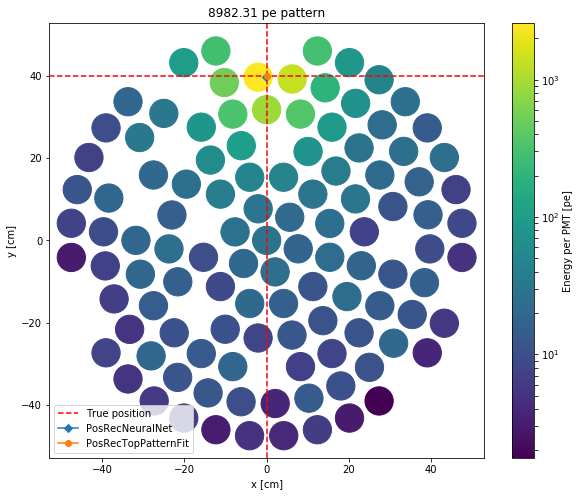

In [16]:
x, y = 0, 40
pat = model(x,y)

pos_dict = model.get_latest_pax_position()

plot_hp(pat)
# Add True position
plt.axhline(y, color='red', linestyle='--', label='True position')
plt.axvline(x, color='red', linestyle='--')
plt.title('%.2f pe pattern' % pat.sum())

# Add markers for the reconstructed pax position
if not pos_dict == {}:
    for (marker, algo) in [('D', 'PosRecNeuralNet'), ('o', 'PosRecTopPatternFit')]:
        plt.plot(pos_dict[algo]['x'], pos_dict[algo]['y'], marker=marker, label=algo)

plt.legend(loc='lower left')
plt.show()

In [17]:
for swf in model.output_plugin.last_event.sum_waveforms:
    if swf.name == 'tpc_top':
        wf = swf.samples

In [18]:
ct = model.output_plugin.last_event.main_s2.center_time  # [ns]
ct /= 10  # [sample]

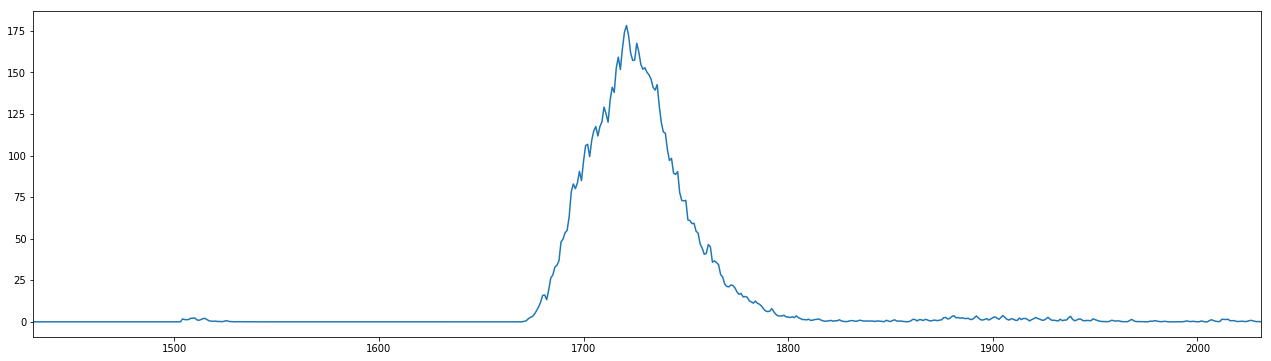

In [19]:
plt.figure(figsize=(22, 6))
plt.plot(wf)
plt.xlim(ct - 300, ct + 300)
plt.show()

## Speed

In [20]:
# The generation and reconstruction can be sped up by disabling more of pax' plugins,
# mainly pax' own position reconstruction. Of course that would require that we store
# the patterns somewhere and process them later with pax to get the pax reconstructed
# positions but then at least the ABC method will run faster.
# The speed also depends on the number of s1_photons and s2_electrons used.

# s1_photons = 500, s2_electrons = 25 -> 3.30it/s, XENON1T_ABC.ini
# s1_photons = 500, s2_electrons = 25 -> 3.73it/s, XENON1T_ABC_minimal.ini
# s1_photons = 50,  s2_electrons = 25 -> 4.04it/s, XENON1T_ABC_minimal.ini


from tqdm import tqdm
from pax.plugins.io.WaveformSimulator import uniform_circle_rv

model.change_defaults(s1_photons = 50, s2_electrons = 25)

patterns = [model(*uniform_circle_rv(tpc_r)) for _ in tqdm(range(100))]

100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


# Python 3.5 and ELFI

In [20]:
import sys
sys.version

'3.5.5 |Anaconda, Inc.| (default, Mar 12 2018, 23:12:44) \n[GCC 7.2.0]'

In [21]:
import elfi